# EDA for visualization

In [21]:
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import numpy
from sklearn.preprocessing import minmax_scale

## Visualize one target

TARGET: 10888 (에픽하이 - 우산 (feat.윤하))

In [5]:
SOURCE_PATH = "/Volumes/vault0/dataset3/chorus-22khz"
FEATURE_CSV_PATH = "./result_22000hz.csv"
TARGET = "10888.wav"

target = os.path.join(SOURCE_PATH, TARGET)
x, sr = librosa.load(target)

print(f"Length: {x.shape}, Sample Rate: {sr}")
ipd.Audio(target)

Length: (661500,), Sample Rate: 22050


### WavePlot

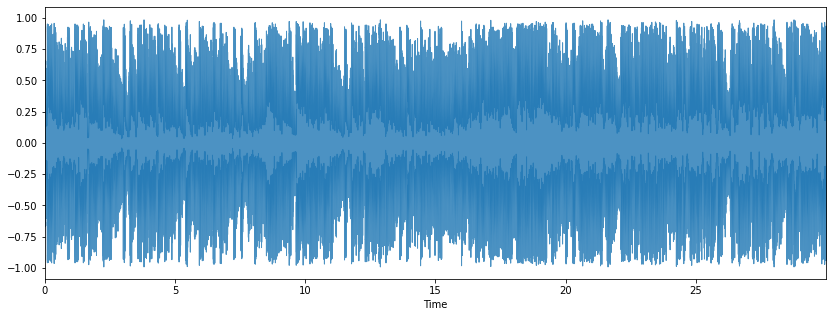

In [17]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.8)

### Spectrogram

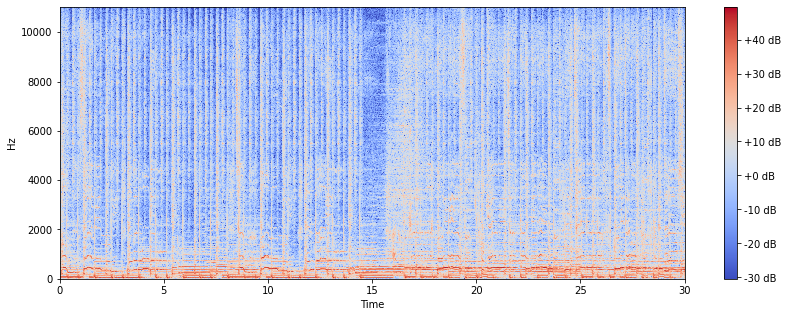

In [7]:
x_stft = librosa.stft(x)
x_db = librosa.amplitude_to_db(abs(x_stft))
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')

### RMSE (Root-square Minimum Energy)
$$ \sqrt{ \frac{1}{N} \sum_n \left| x(n) \right|^2 } $$

In [8]:
n_fft = 2048
frame_length = 512
hop_length = 256

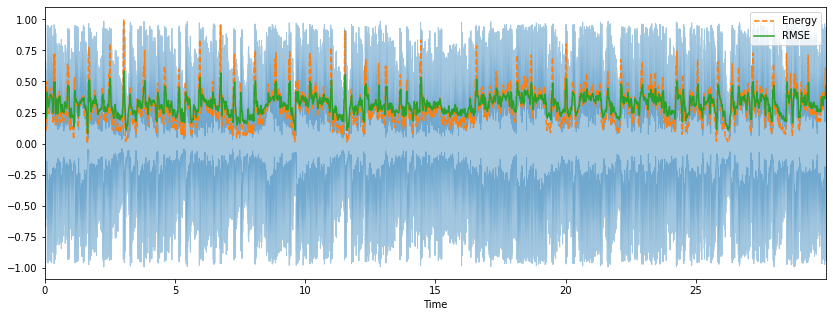

In [9]:
energy = numpy.array([
    sum(abs(x[i:i + frame_length] ** 2))
    for i in range(0, len(x), 256)
])
rmse = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length, center=True)[0]

t = librosa.frames_to_time(range(len(energy)), sr=sr, hop_length=hop_length)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(energy, axis=0), label="Energy", linestyle="dashed")
plt.plot(t, rmse, label="RMSE")
plt.legend()

## Zero Crossing Rate

Indicates the number of times that a signal crosses the horizontal axis.

Zero Crossing count: 55827


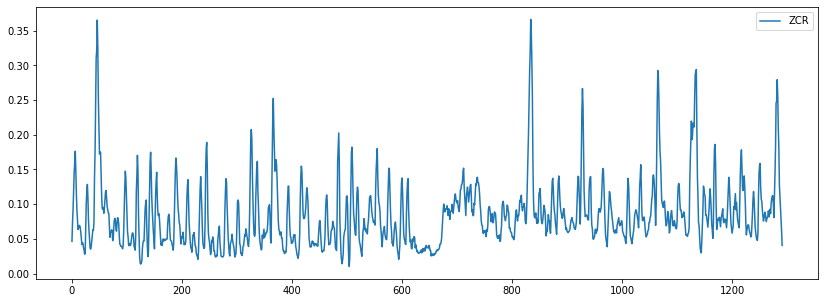

In [30]:
zero_crossings = librosa.zero_crossings(x, pad=False)
zcr = librosa.feature.zero_crossing_rate(x)
print("Zero Crossing count: "+str(sum(zero_crossings)))
plt.figure(figsize=(14, 5))
plt.plot(zcr[0], label="ZCR")
plt.legend()

## Chroma

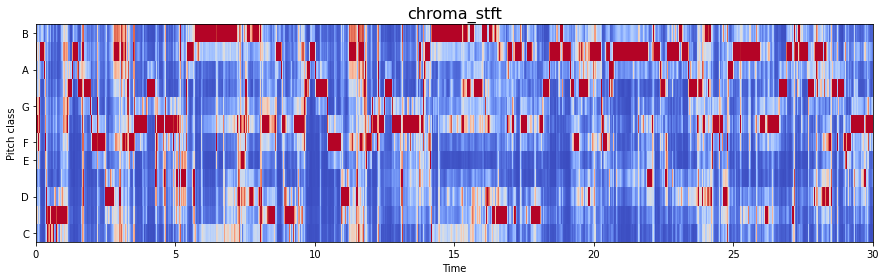

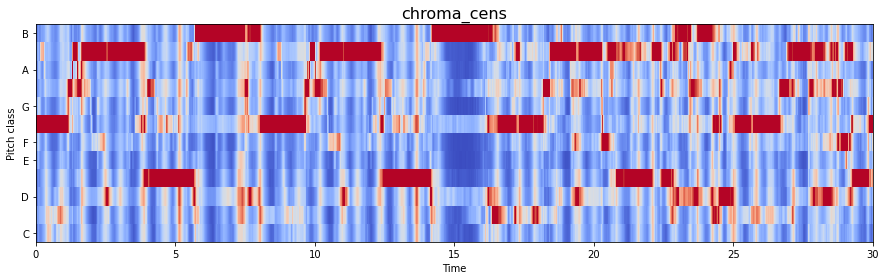

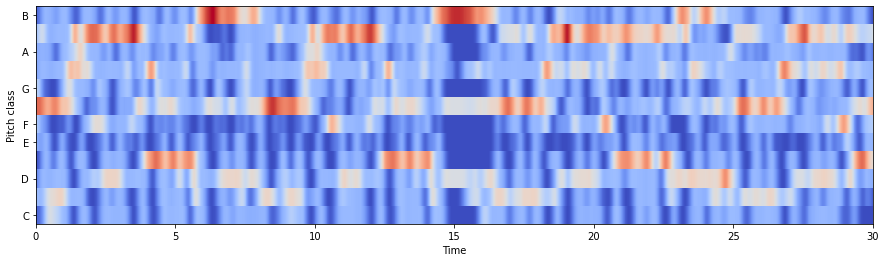

In [11]:
chroma_stft = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
chroma_cqt = librosa.feature.chroma_cqt(x, sr=sr, hop_length=hop_length)
chroma_cens = librosa.feature.chroma_cens(x, sr=sr, hop_length=hop_length)

plt.figure(figsize=(15, 4))
plt.title('chroma_stft', fontsize=16)
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.figure(figsize=(15, 4))
plt.title('chroma_cqt', fontsize=16)
librosa.display.specshow(chroma_cqt, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('chroma_cens', fontsize=16)
plt.figure(figsize=(15, 4))
librosa.display.specshow(chroma_cens, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

## Spectral Features

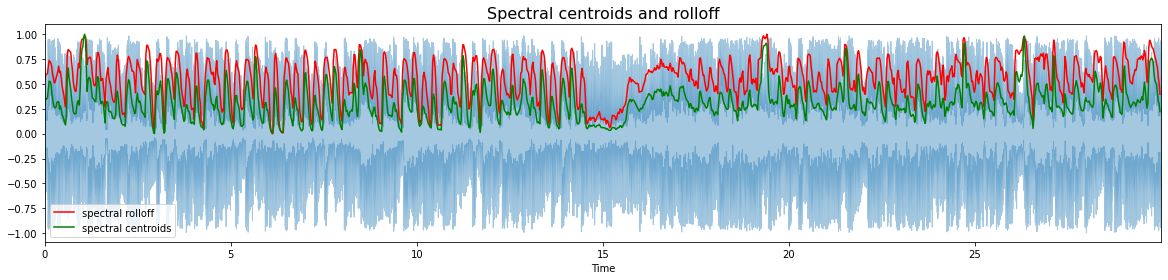

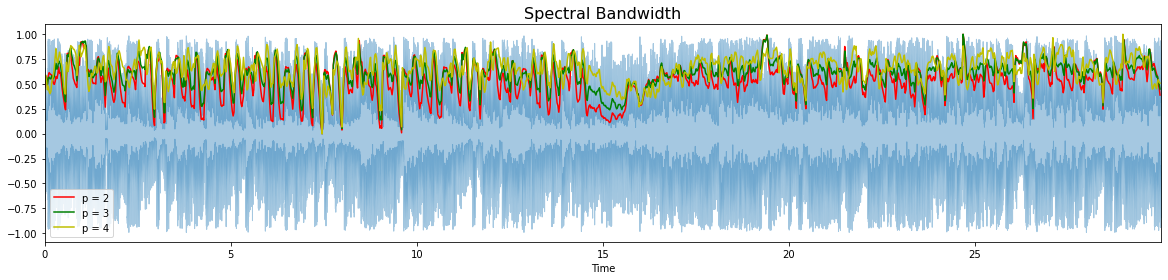

In [28]:
# Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(x+0.01, sr=sr)[0]
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(20, 4))
plt.title('Spectral centroids and rolloff', fontsize=16)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_rolloff), color='r')
plt.plot(t, minmax_scale(spectral_centroids), color='g')
plt.legend(('spectral rolloff', 'spectral centroids'))

# Spectral Bandwidth
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]

plt.figure(figsize=(20, 4))
plt.title('Spectral Bandwidth', fontsize=16)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_bandwidth_2), color='r')
plt.plot(t, minmax_scale(spectral_bandwidth_3), color='g')
plt.plot(t, minmax_scale(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

## MFCC (Mel Frequency Cepstral Coefficient)

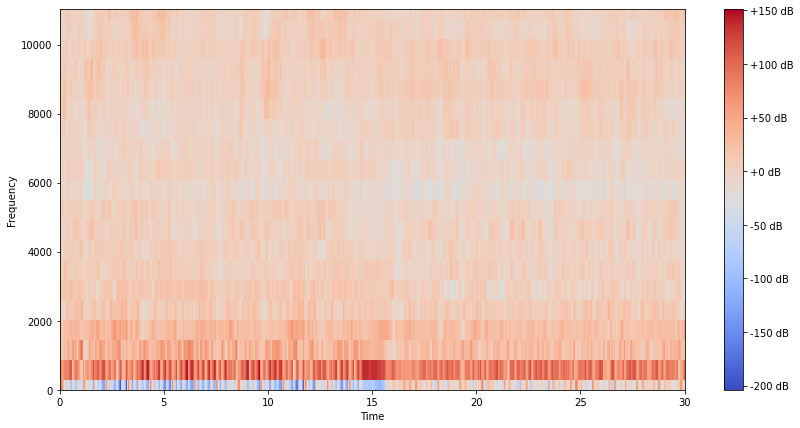

In [12]:
MFCCs = librosa.feature.mfcc(x,
                             sr = sr,
                             n_fft = n_fft,
                             hop_length = hop_length,
                             n_mfcc = 20)
plt.figure(figsize = (14,7))
librosa.display.specshow(MFCCs,
                         sr=sr,
                         hop_length=hop_length,
                         x_axis='time',y_axis="hz")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()

## Tempo

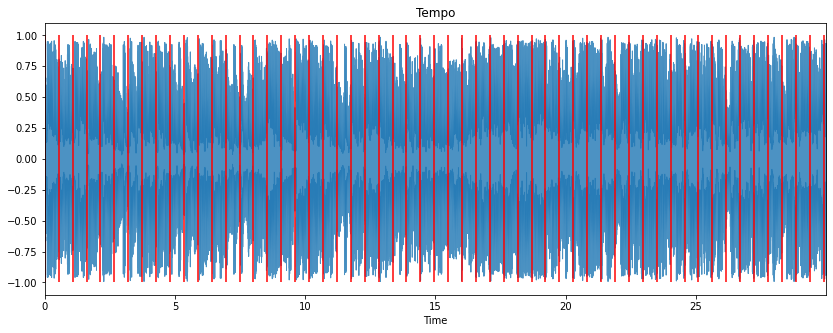

In [35]:
tempo = librosa.beat.tempo(x, sr=sr)
T = len(x)/float(sr)
seconds_per_beat = 60.0/tempo[0]
beat_times = numpy.arange(0, T, seconds_per_beat)

plt.figure(figsize=(14, 5))
plt.title("Tempo")
librosa.display.waveplot(x, alpha=0.8)
plt.vlines(beat_times, -1, 1, color='r')

clicks = librosa.clicks(beat_times, sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)

# Dataset Visualization
PCA와 t-SNE를 사용한 차원 축소의 효과에 대해 각각 비교하여 보고, clustering을 수행 후 t-SNE를 사용하여 결과를 시각화한다.

In [2]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import numpy as np

def load_data(path):
    data=pd.read_csv(path, index_col=[0], header=[0, 1, 2])
    return data

# 데이터 불러오기
data = load_data("result_22000hz.csv")
pd.set_option('display.max_columns', None)
data.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
4666         -0.729028  0.832228 -0.513690 -0.700464 -0.818676 -1.229340   
10750        -0.379960  0.619170  0.062697 -1.015120  0.756527 -0.288884   
5578         -0.632830 -0.744761  1.307000 -0.089473 -0.014075 -1.075960   
9342         -0.427392  0.624676 -1.273800 -0.060483 -0.282734 -0.628239   
9424          0.562450 -0.322334 -0.526117 -1.065830 -0.981241  0.895980   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666       -0.543615  0.086986 -0.795790 -0.677729 -0.641343 -0.892135   
10750       1.189940 -1.452580 -0.853908 -0.796916  0.476290 -0.396949   
5578       -0.737363 -1.226090 -1.001870 -0.366164 -0.086157 -0.900775   
9342       -0.682002 -0.891044 -0.992580 -0.886848 -0.422428 -0.281096   
9424       -0.888102 -0.589333 -1.436570  0.156977 -0.749265 -0.766131   

feature                                                                 \
statistics       max                                                     
number            01        02        03        04        05        06   
4666        0.544107  0.604034  0.414754  0.462633  0.624794  0.656278   
10750       0.442064  0.513720  0.420794  0.642864  0.565786  0.602308   
5578        0.679586  0.584733  0.563848  0.454904  0.487789  0.750612   
9342        0.478865  0.433245  0.527774  0.524504  0.565325  0.533487   
9424        0.491448  0.385233  0.620992  0.651575  0.623663  0.691128   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666        0.667936  0.583116  0.613986  0.666953  0.666598  0.598831   
10750       0.330514  0.513748  0.246647  0.443337  0.317393  0.404017   
5578        0.737776  0.731817  0.451476  0.396555  0.534723  0.553396   
9342        0.709599  0.743491  0.601329  0.511607  0.373566  0.591174   
9424        0.878250  0.615561  0.615091  0.651403  0.545569  0.500132   

feature                                                                 \
statistics      mean                                                     
number            01        02        03        04        05        06   
4666        0.284588  0.249800  0.193049  0.238775  0.315664  0.278817   
10750       0.235872  0.346961  0.230024  0.406954  0.412180  0.367868   
5578        0.286754  0.210008  0.134460  0.131369  0.170917  0.330451   
9342        0.179619  0.103197  0.194881  0.216957  0.219897  0.291707   
9424        0.127545  0.096227  0.288930  0.273375  0.222092  0.177525   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666        0.246120  0.141950  0.201622  0.220370  0.263412  0.300465   
10750       0.193360  0.211944  0.112435  0.250360  0.124142  0.195922   
5578        0.289042  0.390088  0.181282  0.135113  0.215374  0.327244   
9342        0.375506  0.424195  0.275593  0.256154  0.166929  0.233366   
9424        0.449238  0.208853  0.248760  0.222130  0.190737  0.221992   

feature                                                                 \
statistics    median                                                     
number            01        02        03        04        05        06   
4666        0.294625  0.251976  0.193162  0.251647  0.337930  0.275794   
10750       0.220105  0.347689  0.220557  0.403823  0.430291  0.377685   
5578        0.265473  0.185603  0.105753  0.122217  0.15

In [3]:
# Set default Matplotlib style
plt.rcParams["figure.figsize"] = (18,13)

## Elbow Method
Using Elbow method to get optimal K-Means clustering nums

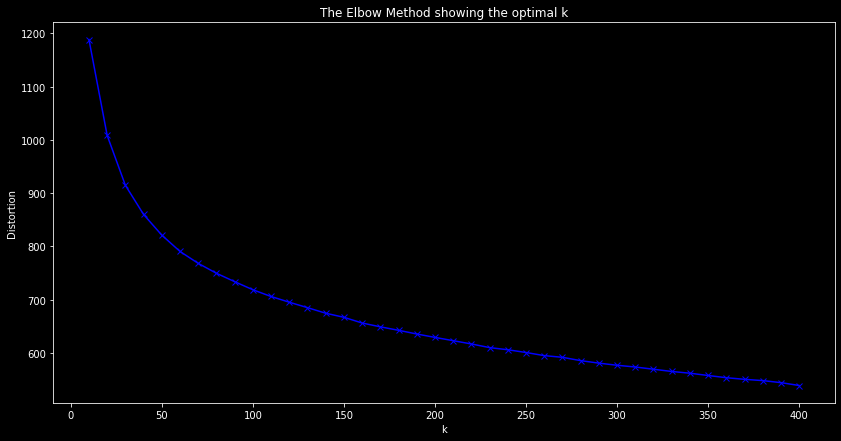

In [4]:
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist

distortions = []
K = range(10, 401, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data)
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])

# Plot the elbow
plt.figure(figsize=(14,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## 0: t-SNE and PCA for raw data

In [5]:
# 2차원으로 차원 축소
n_components = 2
data_labels=["_".join(a) for a in data.columns.to_flat_index()]

# t-sne 모델 생성 및 수행
model_tsne = TSNE(n_components=n_components, learning_rate=300)
time_start=time.time()
tsne=pd.DataFrame(model_tsne.fit_transform(data), columns=['x1','x2'])
tsne.set_index(data.index, inplace=True)
print(f"t-SNE Done. Elepsed Time:{time.time()-time_start}")

# PCA 수행
from sklearn.decomposition import PCA

model_pca = PCA(n_components=2)
time_start=time.time()
pca = pd.DataFrame(model_pca.fit_transform(data), columns=['x1','x2'])
pca.set_index(data.index, inplace=True)
print(f"PCA Done. Elepsed Time:{time.time()-time_start}")


t-SNE Done. Elepsed Time:15.650992155075073
PCA Done. Elepsed Time:0.1024930477142334


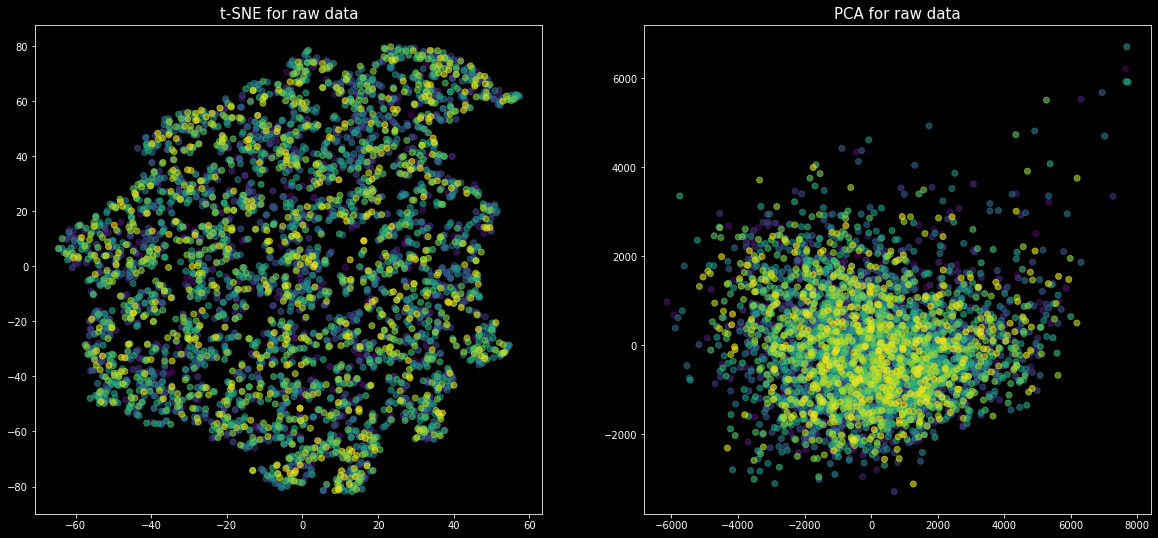

In [6]:
# t-SNE와 PCA 수행 결과 2차원 공간에 출력
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.title("t-SNE for raw data", fontsize=15)
r0_plot_tsne=plt.scatter(tsne['x1'], tsne['x2'], c=range(0, tsne.shape[0]), cmap='viridis', alpha=0.6)

plt.subplot(1,2,2)
plt.title("PCA for raw data", fontsize=15)
r0_plot_pca=plt.scatter(pca['x1'], pca['x2'], c=range(0, pca.shape[0]), cmap='viridis', alpha=0.6)


## 1: K-Means Clustering for raw data

In [7]:
from sklearn.cluster import KMeans 
N_CLUSTERS=200

# k-means clustering 모델 생성
kmeans = KMeans(n_clusters=N_CLUSTERS)

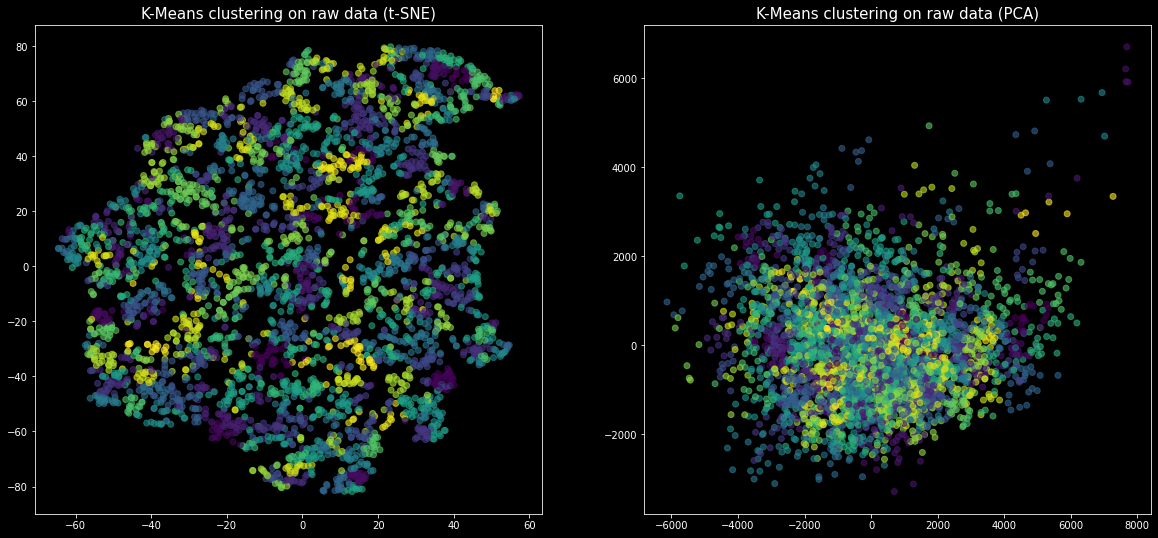

In [16]:
# run clustering
r1=pd.DataFrame(kmeans.fit_predict(data), columns=["cluster"])
r1.set_index(data.index, inplace=True)

# run t-SNE
# r1_data=data.copy()
# r1_data["clusters"]=r1.values
# r1_tsne=TSNE(n_components=n_components, learning_rate=300).fit_transform(r1_data)

# plt.title("t-SNE on K-Means clustering", fontsize=15)
# plt.scatter(r1_tsne[:,0], r1_tsne[:,1], c=r1.values, cmap='viridis', alpha=0.6)
# plt.colorbar()
# plt.show()

plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.title("K-Means clustering on raw data (t-SNE)", fontsize=15)
r1_plot1 = plt.scatter(tsne['x1'], tsne['x2'], c=r1.values, cmap='viridis', alpha=0.6)
plt.subplot(1,2,2)
plt.title("K-Means clustering on raw data (PCA)", fontsize=15)
r1_plot2 = plt.scatter(pca['x1'], pca['x2'], c=r1.values, cmap='viridis', alpha=0.6)
plt.show()

## 2: K-Means clustering after t-SNE

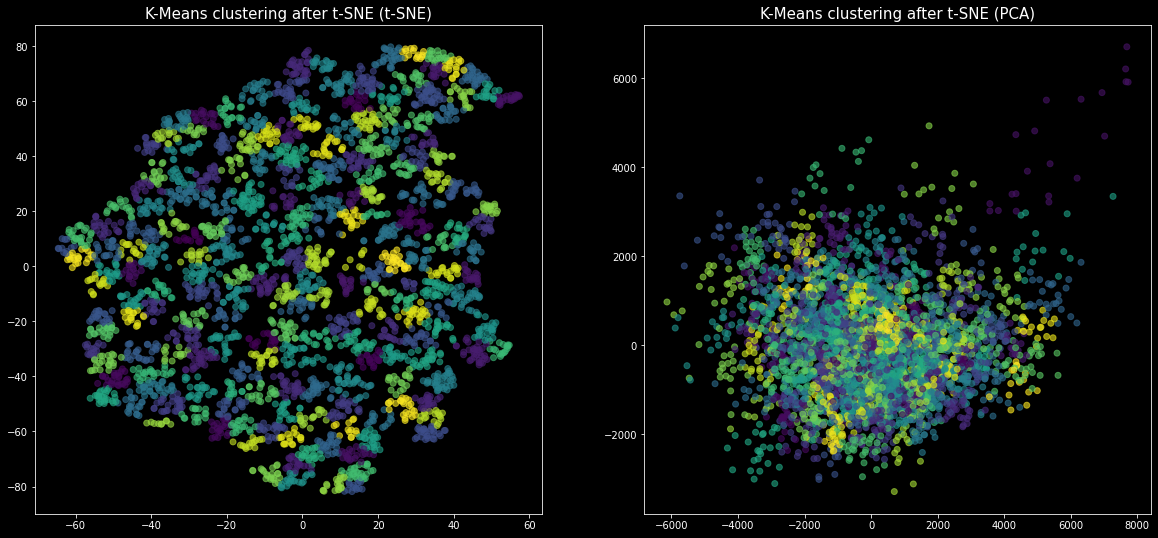

In [9]:
r2=pd.DataFrame(kmeans.fit_predict(tsne), columns=["cluster"])
r2.set_index(data.index, inplace=True)

plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.title("K-Means clustering after t-SNE (t-SNE)", fontsize=15)
r2_plot1 = plt.scatter(tsne['x1'], tsne['x2'], c=r2.values, cmap='viridis', alpha=0.6)
plt.subplot(1,2,2)
plt.title("K-Means clustering after t-SNE (PCA)", fontsize=15)
r2_plot2 = plt.scatter(pca['x1'], pca['x2'], c=r2.values, cmap='viridis', alpha=0.6)

## 3: K-Means clustering after PCA

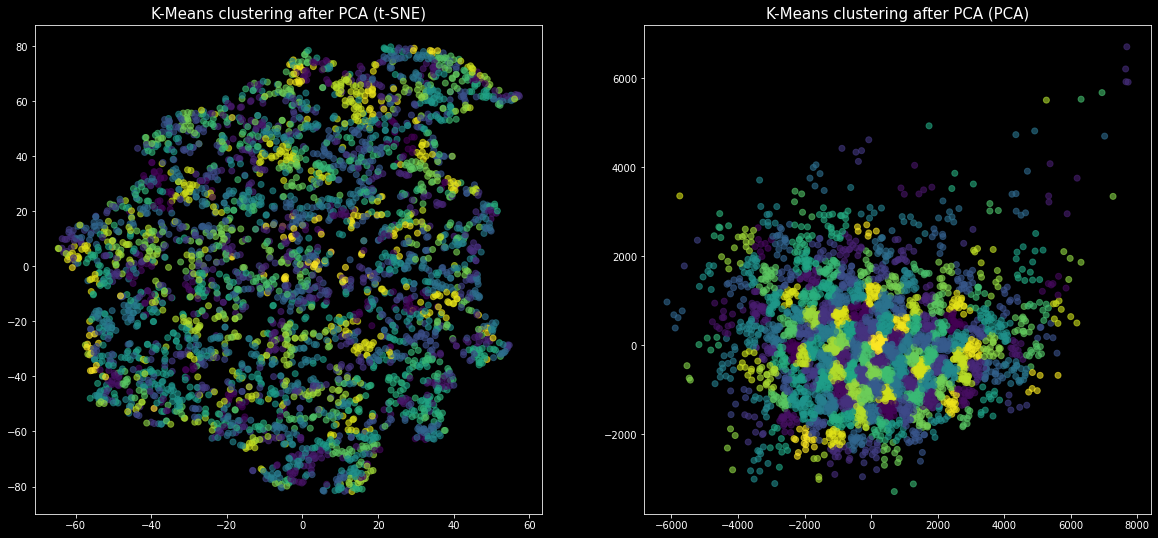

In [10]:
r3=pd.DataFrame(kmeans.fit_predict(pca), columns=["cluster"])
r3.set_index(data.index, inplace=True)

plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.title("K-Means clustering after PCA (t-SNE)", fontsize=15)
r3_plot1 = plt.scatter(tsne['x1'], tsne['x2'], c=r3.values, cmap='viridis', alpha=0.6)

plt.subplot(1,2,2)
plt.title("K-Means clustering after PCA (PCA)", fontsize=15)
r3_plot2 = plt.scatter(pca['x1'], pca['x2'], c=r3.values, cmap='viridis', alpha=0.6)


## Select reduced demension target for PCA

In [11]:
# 95% 분산 유지를 위한 최소한의 차원 수를 계산하여 PCA 모델에 적용
model_pca_opt = PCA(n_components=0.95)
pca_opt = model_pca_opt.fit_transform(data)
print(f"Number of demension: {model_pca_opt.n_components_}")

Number of demension: 4


## 4: K-Means Clustering for optimized PCA

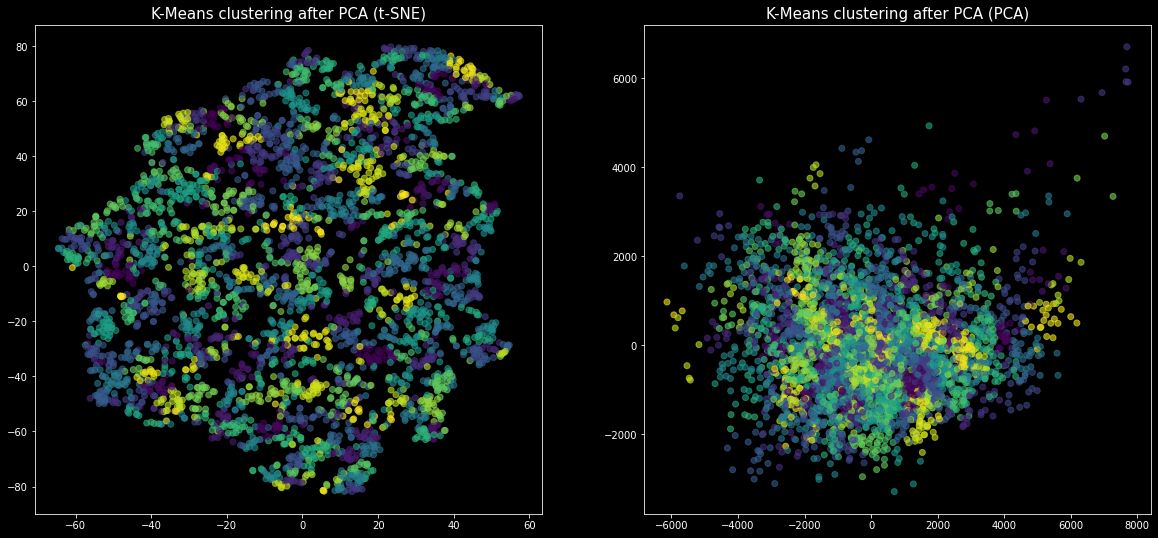

In [14]:
r4=pd.DataFrame(kmeans.fit_predict(pca_opt), columns=["cluster"])
r4.set_index(data.index, inplace=True)

plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.title("K-Means clustering after PCA (t-SNE)", fontsize=15)
r4_plot = plt.scatter(tsne['x1'], tsne['x2'], c=r4.values, cmap='viridis', alpha=0.6)

plt.subplot(1,2,2)
plt.title("K-Means clustering after PCA (PCA)", fontsize=15)
r4_plot = plt.scatter(pca['x1'], pca['x2'], c=r4.values, cmap='viridis', alpha=0.6)

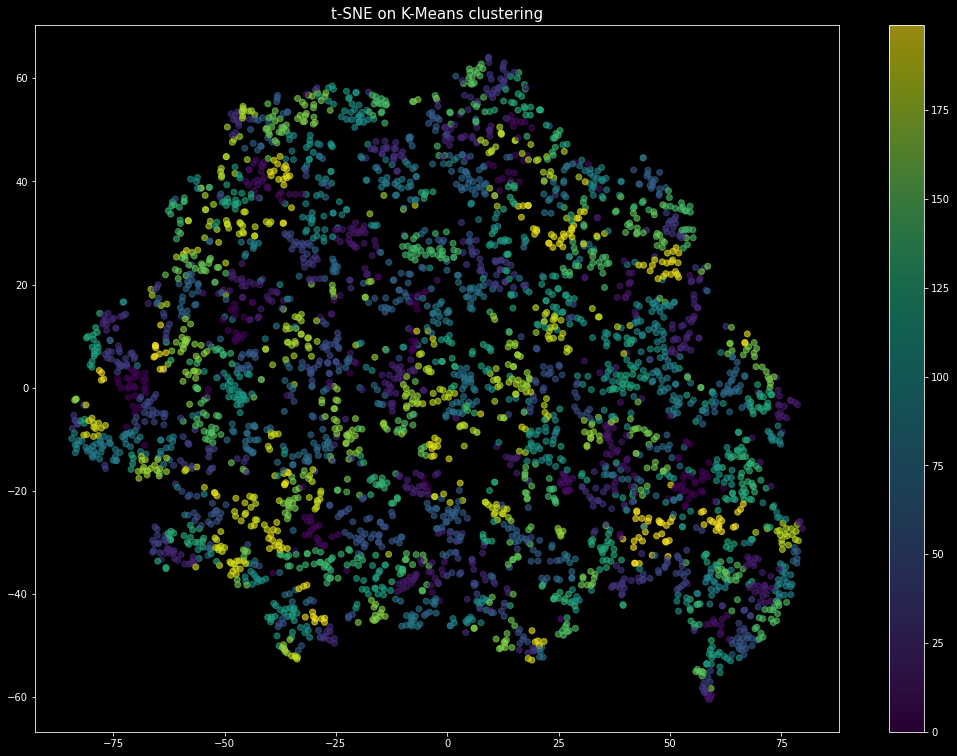

In [13]:
# run t-SNE
r4_data=data.copy()
r4_data["clusters"]=r4.values
r4_tsne=TSNE(n_components=n_components, learning_rate=300).fit_transform(r4_data)

plt.title("t-SNE on K-Means clustering", fontsize=15)
plt.scatter(r4_tsne[:,0], r4_tsne[:,1], c=r4.values, cmap='viridis', alpha=0.6)
plt.colorbar()
plt.show()

## 5: K-Means with optimized PCA, dropping some features

In [48]:
data.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
4666         -0.729028  0.832228 -0.513690 -0.700464 -0.818676 -1.229340   
10750        -0.379960  0.619170  0.062697 -1.015120  0.756527 -0.288884   
5578         -0.632830 -0.744761  1.307000 -0.089473 -0.014075 -1.075960   
9342         -0.427392  0.624676 -1.273800 -0.060483 -0.282734 -0.628239   
9424          0.562450 -0.322334 -0.526117 -1.065830 -0.981241  0.895980   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666       -0.543615  0.086986 -0.795790 -0.677729 -0.641343 -0.892135   
10750       1.189940 -1.452580 -0.853908 -0.796916  0.476290 -0.396949   
5578       -0.737363 -1.226090 -1.001870 -0.366164 -0.086157 -0.900775   
9342       -0.682002 -0.891044 -0.992580 -0.886848 -0.422428 -0.281096   
9424       -0.888102 -0.589333 -1.436570  0.156977 -0.749265 -0.766131   

feature                                                                 \
statistics       max                                                     
number            01        02        03        04        05        06   
4666        0.544107  0.604034  0.414754  0.462633  0.624794  0.656278   
10750       0.442064  0.513720  0.420794  0.642864  0.565786  0.602308   
5578        0.679586  0.584733  0.563848  0.454904  0.487789  0.750612   
9342        0.478865  0.433245  0.527774  0.524504  0.565325  0.533487   
9424        0.491448  0.385233  0.620992  0.651575  0.623663  0.691128   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666        0.667936  0.583116  0.613986  0.666953  0.666598  0.598831   
10750       0.330514  0.513748  0.246647  0.443337  0.317393  0.404017   
5578        0.737776  0.731817  0.451476  0.396555  0.534723  0.553396   
9342        0.709599  0.743491  0.601329  0.511607  0.373566  0.591174   
9424        0.878250  0.615561  0.615091  0.651403  0.545569  0.500132   

feature                                                                 \
statistics      mean                                                     
number            01        02        03        04        05        06   
4666        0.284588  0.249800  0.193049  0.238775  0.315664  0.278817   
10750       0.235872  0.346961  0.230024  0.406954  0.412180  0.367868   
5578        0.286754  0.210008  0.134460  0.131369  0.170917  0.330451   
9342        0.179619  0.103197  0.194881  0.216957  0.219897  0.291707   
9424        0.127545  0.096227  0.288930  0.273375  0.222092  0.177525   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666        0.246120  0.141950  0.201622  0.220370  0.263412  0.300465   
10750       0.193360  0.211944  0.112435  0.250360  0.124142  0.195922   
5578        0.289042  0.390088  0.181282  0.135113  0.215374  0.327244   
9342        0.375506  0.424195  0.275593  0.256154  0.166929  0.233366   
9424        0.449238  0.208853  0.248760  0.222130  0.190737  0.221992   

feature                                                                 \
statistics    median                                                     
number            01        02        03        04        05        06   
4666        0.294625  0.251976  0.193162  0.251647  0.337930  0.275794   
10750       0.220105  0.347689  0.220557  0.403823  0.430291  0.377685   
5578        0.265473  0.185603  0.105753  0.122217  0.15

In [56]:
data_clean=data.copy()
data_clean.drop(["chroma_cqt", "chroma_stft"], axis=1, inplace=True)
# data_clean.drop("kurtosis", axis=1, level=1)

# Min-max scaling

data_clean.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
4666         -0.729028  0.832228 -0.513690 -0.700464 -0.818676 -1.229340   
10750        -0.379960  0.619170  0.062697 -1.015120  0.756527 -0.288884   
5578         -0.632830 -0.744761  1.307000 -0.089473 -0.014075 -1.075960   
9342         -0.427392  0.624676 -1.273800 -0.060483 -0.282734 -0.628239   
9424          0.562450 -0.322334 -0.526117 -1.065830 -0.981241  0.895980   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666       -0.543615  0.086986 -0.795790 -0.677729 -0.641343 -0.892135   
10750       1.189940 -1.452580 -0.853908 -0.796916  0.476290 -0.396949   
5578       -0.737363 -1.226090 -1.001870 -0.366164 -0.086157 -0.900775   
9342       -0.682002 -0.891044 -0.992580 -0.886848 -0.422428 -0.281096   
9424       -0.888102 -0.589333 -1.436570  0.156977 -0.749265 -0.766131   

feature                                                                 \
statistics       max                                                     
number            01        02        03        04        05        06   
4666        0.544107  0.604034  0.414754  0.462633  0.624794  0.656278   
10750       0.442064  0.513720  0.420794  0.642864  0.565786  0.602308   
5578        0.679586  0.584733  0.563848  0.454904  0.487789  0.750612   
9342        0.478865  0.433245  0.527774  0.524504  0.565325  0.533487   
9424        0.491448  0.385233  0.620992  0.651575  0.623663  0.691128   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666        0.667936  0.583116  0.613986  0.666953  0.666598  0.598831   
10750       0.330514  0.513748  0.246647  0.443337  0.317393  0.404017   
5578        0.737776  0.731817  0.451476  0.396555  0.534723  0.553396   
9342        0.709599  0.743491  0.601329  0.511607  0.373566  0.591174   
9424        0.878250  0.615561  0.615091  0.651403  0.545569  0.500132   

feature                                                                 \
statistics      mean                                                     
number            01        02        03        04        05        06   
4666        0.284588  0.249800  0.193049  0.238775  0.315664  0.278817   
10750       0.235872  0.346961  0.230024  0.406954  0.412180  0.367868   
5578        0.286754  0.210008  0.134460  0.131369  0.170917  0.330451   
9342        0.179619  0.103197  0.194881  0.216957  0.219897  0.291707   
9424        0.127545  0.096227  0.288930  0.273375  0.222092  0.177525   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
4666        0.246120  0.141950  0.201622  0.220370  0.263412  0.300465   
10750       0.193360  0.211944  0.112435  0.250360  0.124142  0.195922   
5578        0.289042  0.390088  0.181282  0.135113  0.215374  0.327244   
9342        0.375506  0.424195  0.275593  0.256154  0.166929  0.233366   
9424        0.449238  0.208853  0.248760  0.222130  0.190737  0.221992   

feature                                                                 \
statistics    median                                                     
number            01        02        03        04        05        06   
4666        0.294625  0.251976  0.193162  0.251647  0.337930  0.275794   
10750       0.220105  0.347689  0.220557  0.403823  0.430291  0.377685   
5578        0.265473  0.185603  0.105753  0.122217  0.15

In [47]:
r1.to_csv("r1.csv")
r2.to_csv("r2.csv")
r3.to_csv("r3.csv")
r4.to_csv("r4.csv")